# CeleBTI Guide for Enraged Emu

###구글 드라이브 setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


## CeleBTILoader
#### : DataLoader in torch

In [ ]:
from dataset.celebti import CeleBTILoader

In [ ]:
loader_train = CeleBTILoader(train=True, shuffle=False)

Annotations download completed. Begin downloading images...
                             


In [ ]:
loader_test = CeleBTILoader(train=False)

Annotations download completed. Begin downloading images...
                             


In [ ]:
print(loader_train.size())
print(loader_test.size())

5052
1066


##이미지 augmentation

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

image_transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    # ColorJitter 적용
    transforms.ColorJitter(brightness=(0.5, 0.9),
                           contrast=(0.4, 0.8),
                           saturation=(0.7, 0.9),
                           hue=(-0.2, 0.2),
    ),
    # RandomHorizontalFlip 적용
    transforms.RandomHorizontalFlip(p=0.5),
    # GaussianBlur 적용
    transforms.GaussianBlur(kernel_size=(19, 19), sigma=(1.0, 2.0)),
    # RandomRotation 적용
    transforms.RandomRotation(degrees=(-30, 30), interpolation=transforms.InterpolationMode.BILINEAR, fill=0),
    transforms.ToTensor()

])

transform_dataset = ImageFolder(root='/content/drive/MyDrive/dataset/Img',                  # 다운로드 받은 폴더의 root 경로를 지정
                                transform=image_transform)

transform_loader = DataLoader(transform_dataset, #
                              shuffle=False,      # 셔플 여부
                              num_workers=1
                             )

## utils

### utils.image_processor
* tensor2image
* image2tensor

In [ ]:
inputs, classes = next(iter(loader_train))

In [ ]:
import utils.image_processor as impro

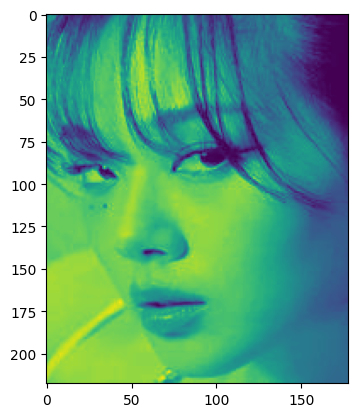

In [ ]:
img_BIBI = impro.tensor2image(inputs[17], verbose=True)

In [ ]:
impro.image2tensor(img_BIBI)

tensor([[[-0.3961, -0.1922,  0.1608,  ..., -1.0000, -1.0000, -1.0000],
         [-0.3333, -0.1765, -0.0039,  ..., -1.0000, -1.0000, -1.0000],
         [-0.2157, -0.0667, -0.0431,  ..., -0.9922, -1.0000, -1.0000],
         ...,
         [ 0.5608,  0.5137,  0.4588,  ..., -0.3725, -0.3961, -0.3961],
         [ 0.4824,  0.4353,  0.4196,  ..., -0.3961, -0.3961, -0.3961],
         [ 0.4824,  0.4353,  0.4196,  ..., -0.3961, -0.3961, -0.3961]]])

### utils.mbti_convertor
* str2onehot
* onehot2str
* tensor2str
* tensor2onehot

In [ ]:
from utils.mbti_convertor import (
    str2onehot,
    onehot2str,
    tensor2str,
    tensor2onehot,
)

In [ ]:
mbti_BIBI = onehot2str(classes[17])
mbti_BIBI

'INFP'

## Training samples

In [ ]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

#utils
import numpy as np
from torchsummary import summary
import time
import copy

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Bottle_Neck(nn.Module):
  expansion = 4 #2 아닌가??
  cardinality = 32
  basewidth = 64  # 기본 bottleneck 채널수  128아닌가???
  depth = 4  # basewidth 일 때, group convolution 의 채널 수

  def __init__(self, in_channels, out_channels, stride): #stride 는 왜 1인가?
    super().__init__()
    c = Bottle_Neck.cardinality
    d = int(Bottle_Neck.depth *out_channels /Bottle_Neck.basewidth)  #한 그룹의 채널 수 : 기본 채널 수에 대한 output채널 수의 비율로 표현

    self.conv_residual = nn.Sequential(
        nn.Conv2d(in_channels,c*d , kernel_size = 1 , groups = c, bias = False),
        nn.BatchNorm2d(c*d), #numfeatures = 입력채널의 개수
        nn.ReLU(),
        nn.Conv2d(c*d,c*d, kernel_size=3, stride = stride,padding =1, groups =c, bias = False),
        nn.BatchNorm2d(c*d),
        nn.ReLU(),
        nn.Conv2d(c*d,out_channels*Bottle_Neck.expansion,kernel_size=1,bias =False), #out channel왜 이렇지?
        nn.BatchNorm2d(out_channels*Bottle_Neck.expansion)
    )

    self.shortcut = nn.Sequential()

    if stride !=1 or in_channels != out_channels*Bottle_Neck.expansion: #그냥 더하는것이 아니라 처리를 해줌
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels*4, stride = stride,kernel_size=1 , bias = False),
          nn.BatchNorm2d(out_channels*4)
      )

  def forward(self, x) :
      return F.relu(self.conv_residual(x)+self.shortcut(x))

In [ ]:
class Res_Next(nn.Module):

  def __init__(self, num_blocks, num_classes=4 , init_weights = True):
    super().__init__()
    self.init_weights = init_weights
    self.in_channels = 64

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,64,7,stride =2 , padding = 2 , bias = False), #패딩은 왜 2?
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(3, stride =2 , padding =1) #
    )

    self.conv2 = self._make_res_block(num_blocks[0],64,1)
    self.conv3 = self._make_res_block(num_blocks[1],128,2)
    self.conv4 = self._make_res_block(num_blocks[2],256,2)
    self.conv5 = self._make_res_block(num_blocks[3],512,2)

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1)) #입력값에 상관없이 출력값의 사이즈를 맞춰주는 pooling
    self.linear = nn.Linear(512*Bottle_Neck.expansion , num_classes)

    if self.init_weights:
      self._initialize_weights()



  def forward(self,x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.avg_pool(x)
      x = x.view(x.size(0), -1)
      x = self.linear(x)
      return x

  def _make_res_block(self, num_blocks, out_channels, stride):
      strides  = [stride]+[1]*(num_blocks-1) #strides = [stride, 1,1,...1]
      res_block = nn.Sequential()

      for i, stride in enumerate(strides):
        res_block.add_module('dense_layer_{}'.format(i),Bottle_Neck(self.in_channels,out_channels,stride))
        self.in_channels = out_channels*Bottle_Neck.expansion

      return res_block


  def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode ='fan_out', nonlinearity='relu') #he-normal(relu 함수 사용할 떄 0으로 수렴하는 문제 해결하기 위한)
          if m.bias is not None:
            nn.init.constant_(m.bias,0)
          elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight,1)
            nn.init.constant_(m.bias,0)
          elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight,0,0.01)
            nn.init.constant_(m.bias,0)



In [ ]:
def Res_Next50():
  return Res_Next([3,4,6,3])

In [ ]:
"""
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                                    nn.GELU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                    nn.GELU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(152064, 4)

        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
"""

In [ ]:
model = Res_Next50()
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

In [ ]:
def train(max_epochs):
    model.train()

    for epoch in range(max_epochs):
        for batch_idx, samples in enumerate(loader_train):
            data, targets = samples

            opt.zero_grad()
            outputs = model(data)
            cost = loss(outputs, targets)

            cost.backward()
            opt.step()

            print("Epoch {:3d}/{} | batch {:2d} | loss = {:5f}".format(epoch + 1, max_epochs, batch_idx + 1, cost.item()))

In [ ]:
def accuracy(for_testset=True):
    loader = loader_test if for_testset else loader_train
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, targets in loader:
            outputs = model(data)

            for i in range(targets.shape[0]):
                if torch.equal(targets[i], tensor2onehot(outputs.data[i])):
                    correct += 1

        data_num = loader.size()
        anno = 'Test' if for_testset else 'Train'
        print('{} accuracy = {:%}'.format(anno, correct/data_num))

Accuracy before training

In [ ]:
#resnext50
accuracy(for_testset=False)
accuracy(for_testset=True)

Train accuracy = 5.482977%
Test accuracy = 6.003752%


Training

In [ ]:
train(3)

Accuracy after training

In [ ]:
accuracy(for_testset=False)
accuracy(for_testset=True)

Train accuracy = 5.502771%
Test accuracy = 6.003752%
